In [57]:
import sys
# sys.path.append('/home/ajhnam/plinko_nn/src')
sys.path.append('/home/plinkoproj/plinko_nn/src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.misc import plot as plinko_plot

# import matplotlib.pyplot as plt
# from plotnine import *
# %matplotlib inline

In [2]:
device = 0
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

In [3]:
repo_path = '/home/plinkoproj/plinko_nn'
df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

In [4]:
sim_data = data_utils.get_sim_data(df_ball, df_col)
selected_runs = sim_data[(sim_data.num_collisions == 1)
                         & (sim_data.duration < 100)
                         & (sim_data.run <= 20)]
simulations, environments = data_utils.create_task_df(selected_runs, df_ball, df_env)
states, envs = data_utils.to_tensors(simulations, environments, device)

In [5]:
# print(selected_runs)
# print(states)

In [6]:
def get_logp_loss(gm, targets):
    return -gm.log_p(targets).mean()

def get_mu_mse_loss(gm, targets):
    return F.mse_loss(gm.mu[:,:,0], targets)

def get_mu_position(gm):
    return gm.mu[:,:,0]

In [51]:
model = GRUPredictor(env_size=11, state_size=2, num_gaussians=1).to(device)
# optimizer = optim.SGD(model.parameters(), lr=.001)
optimizer = optim.Adam(model.parameters(), weight_decay=.001)
dataset = SimulationDataset(envs, states)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# print(dataloader)

# for batch_i, batch in enumerate(dataloader):
#     if batch_i == 0:
#         print(batch_i)
#         print(batch['states'][0])
#         print(batch['targets'][0])

Epoch 0 | logp: 22.6366 | mse: 2.5235 | total: 25.1601


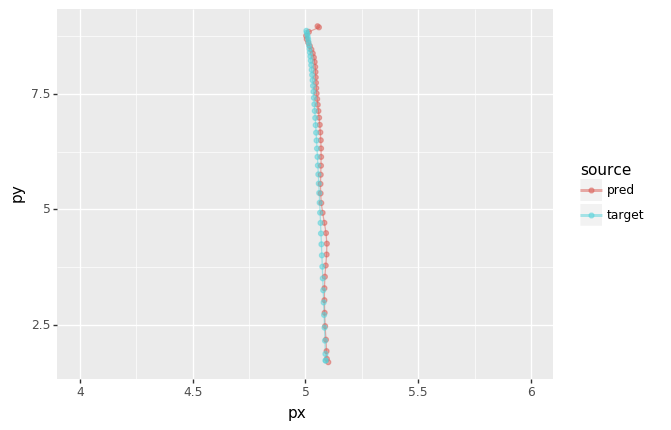

<ggplot: (8794431723453)>
Epoch 5 | logp: -139.5319 | mse: 3.2902 | total: -136.2418


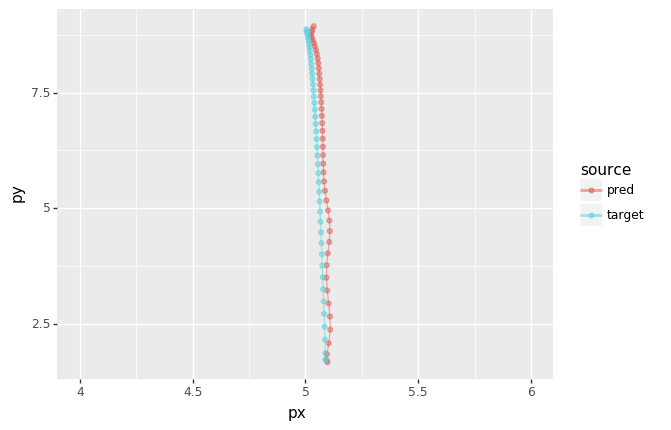

<ggplot: (8794431643381)>
Epoch 10 | logp: -98.2354 | mse: 4.1855 | total: -94.05


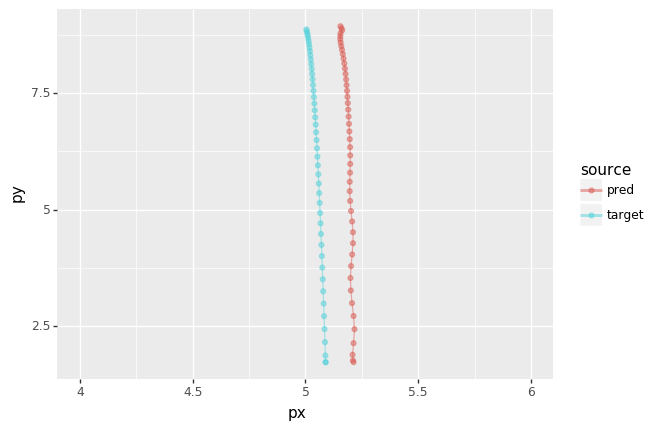

<ggplot: (8794432058997)>
Epoch 15 | logp: -93.5582 | mse: 3.503 | total: -90.0552


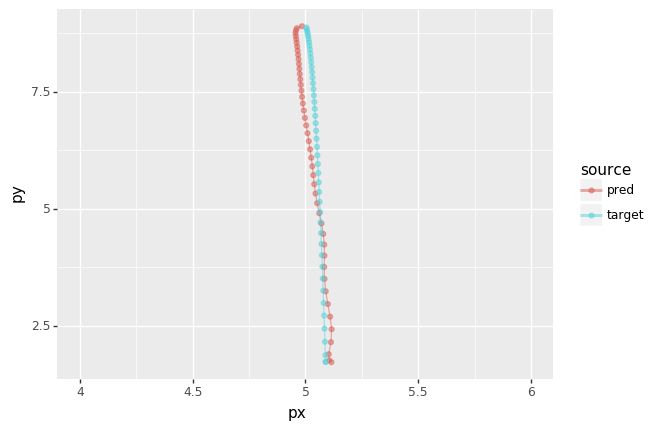

<ggplot: (8794432063209)>
Epoch 20 | logp: -148.0436 | mse: 0.5953 | total: -147.4483


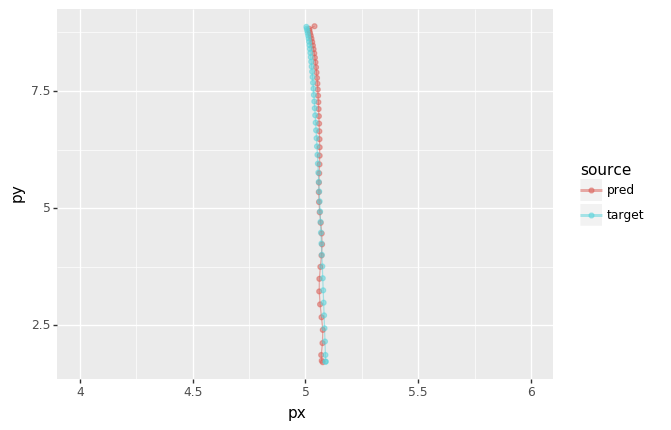

<ggplot: (8794431528949)>
Epoch 25 | logp: 81.3486 | mse: 19.5176 | total: 100.8661


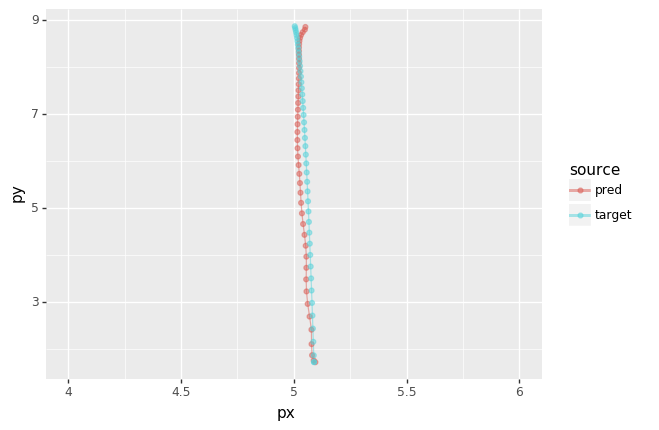

<ggplot: (8794494951053)>
Epoch 30 | logp: -179.3251 | mse: 2.1408 | total: -177.1843


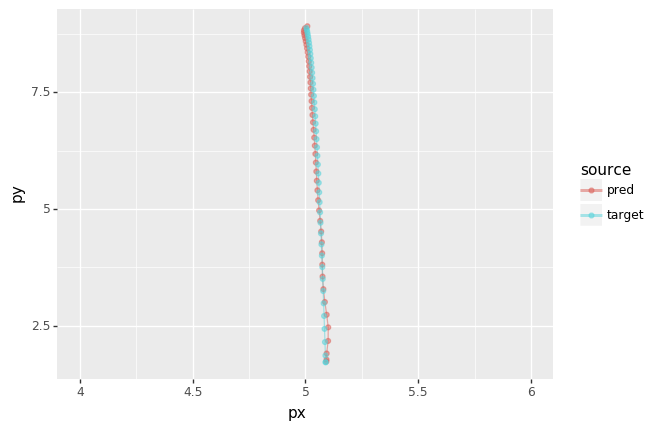

<ggplot: (8794431871785)>
Epoch 35 | logp: -79.3794 | mse: 8.1923 | total: -71.187


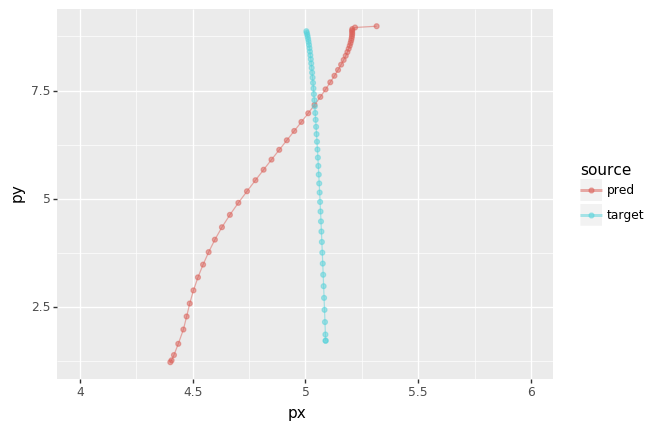

<ggplot: (8794431649153)>
Epoch 40 | logp: -139.1467 | mse: 3.1309 | total: -136.0159


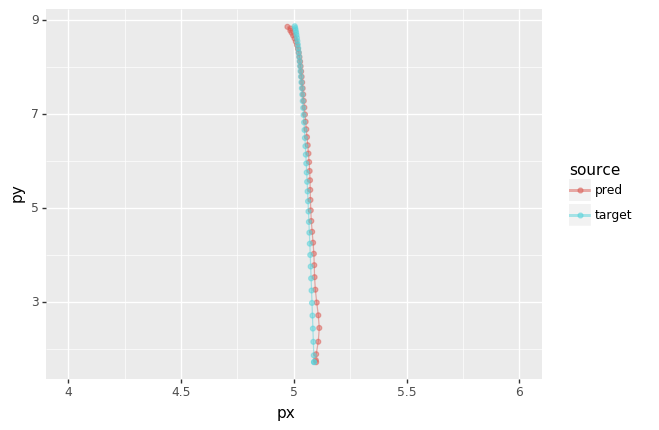

<ggplot: (8794431524941)>
Epoch 45 | logp: -142.9132 | mse: 1.1927 | total: -141.7205


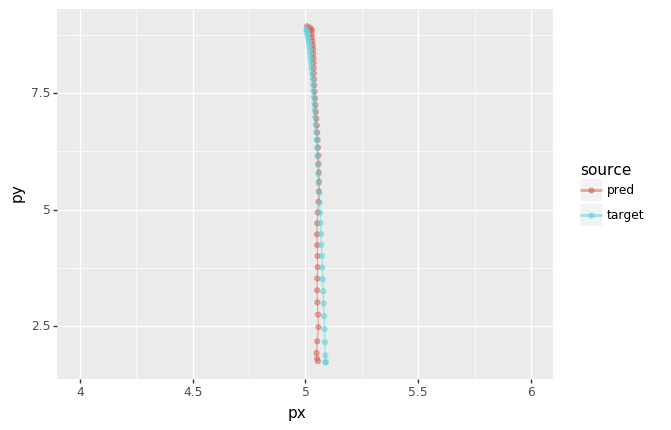

<ggplot: (8794478305789)>
Epoch 50 | logp: -41.3407 | mse: 2.0157 | total: -39.325


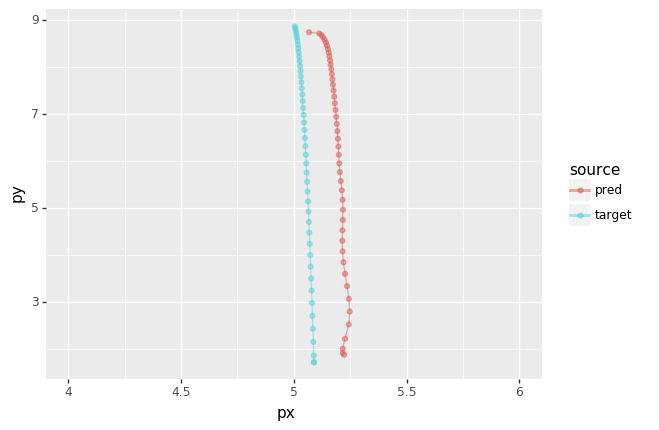

<ggplot: (8794431828449)>
Epoch 55 | logp: -116.1895 | mse: 0.6445 | total: -115.5451


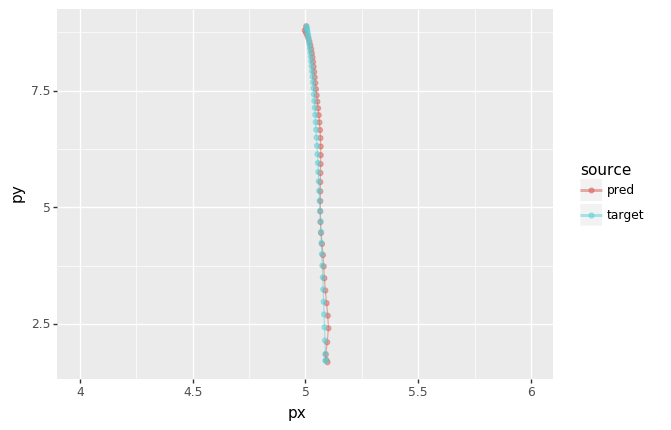

<ggplot: (8794431528949)>
Epoch 60 | logp: -145.6336 | mse: 0.7914 | total: -144.8422


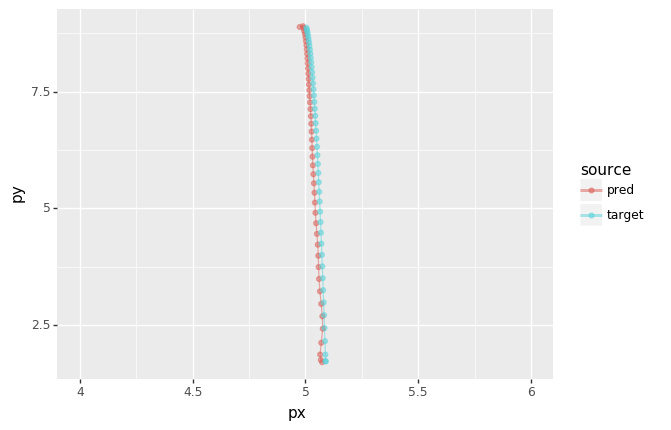

<ggplot: (8794431812085)>
Epoch 65 | logp: -92.3734 | mse: 2.3058 | total: -90.0676


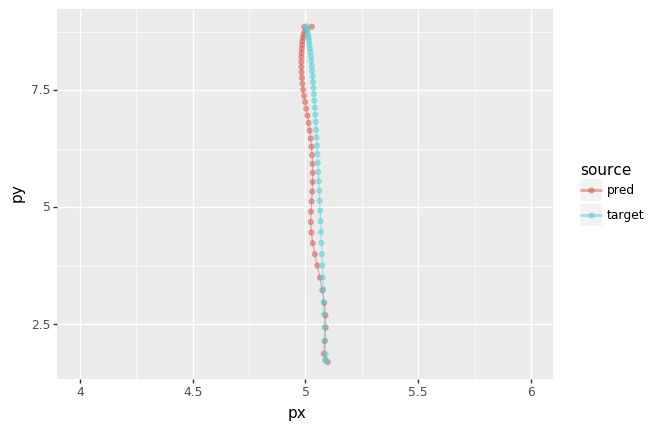

<ggplot: (8794431703409)>
Epoch 70 | logp: 70.8061 | mse: 37.0356 | total: 107.8417


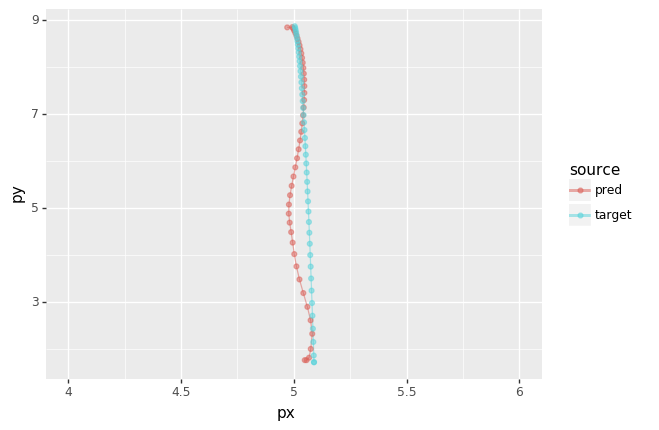

<ggplot: (8794431575049)>
Epoch 75 | logp: -136.5918 | mse: 1.9501 | total: -134.6417


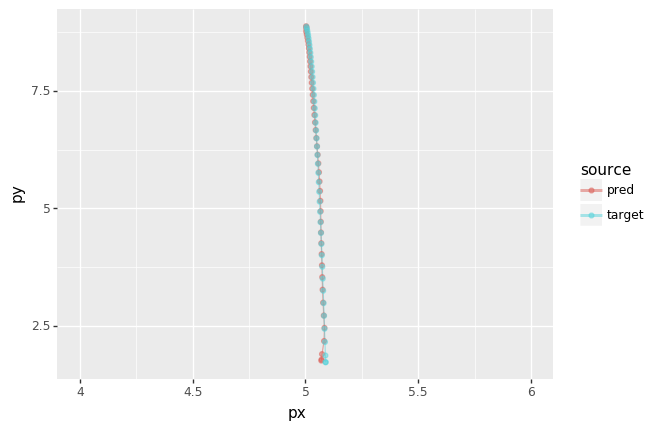

<ggplot: (8794494977597)>
Epoch 80 | logp: -150.1778 | mse: 2.7236 | total: -147.4542


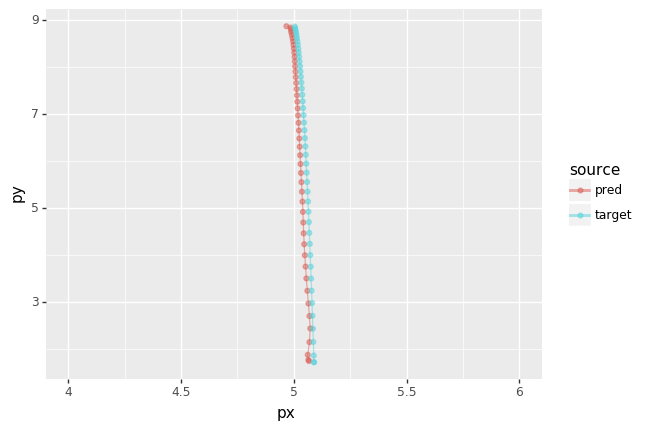

<ggplot: (8794431753957)>
Epoch 85 | logp: -195.8783 | mse: 2.1998 | total: -193.6786


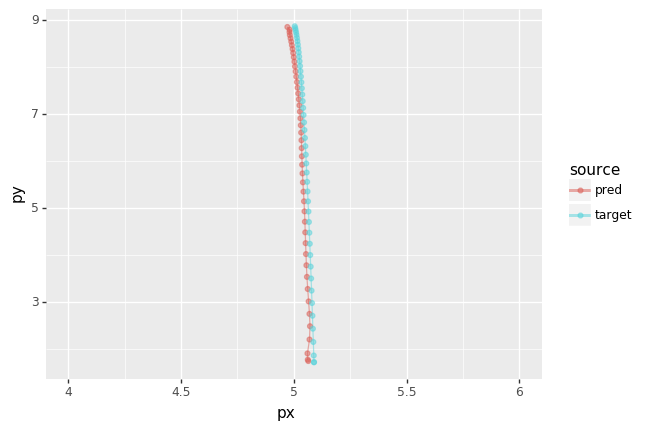

<ggplot: (8794488530449)>
Epoch 90 | logp: -186.0388 | mse: 1.8509 | total: -184.1879


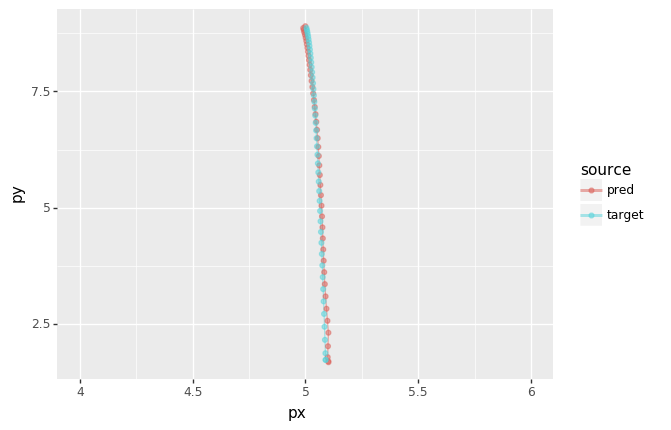

<ggplot: (8794431957545)>
Epoch 95 | logp: -122.3212 | mse: 1.4425 | total: -120.8787


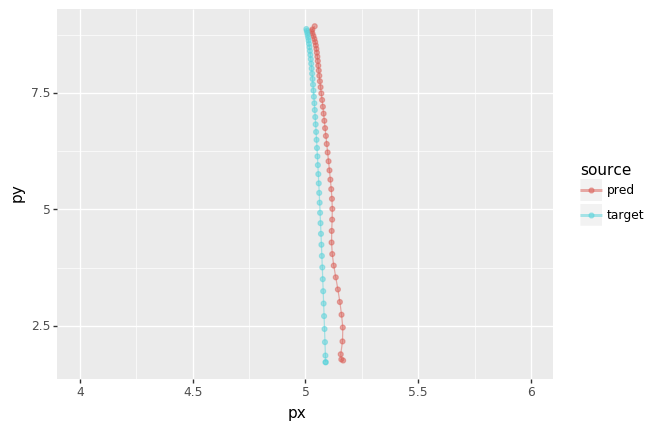

<ggplot: (8794478287093)>



In [58]:
max_t = simulations.t.max()
epochs = 100
losses = []
for epoch in tqdm(range(epochs+1)):
# for epoch in tqdm(range(100)):
    epoch_loss = 0
    epoch_mse_loss = 0
    epoch_logp_loss = 0
    for batch_i, batch in enumerate(dataloader):
        optimizer.zero_grad()
            
        gm = model(batch['envs'], batch['states'], 0)
        targets = batch['targets']
        
        logp_loss = get_logp_loss(gm, targets)
        mse_loss = 10*get_mu_mse_loss(gm, targets)
        loss = logp_loss + mse_loss
        loss.backward(retain_graph=True)
        optimizer.step()
        epoch_loss += loss
        epoch_logp_loss += logp_loss
        epoch_mse_loss += mse_loss
        losses.append((epoch, batch_i, float(loss)))

    
    if epoch%5 == 0:
        print('Epoch {} | logp: {} | mse: {} | total: {}'.format(epoch,
                                                                 round(float(epoch_logp_loss), 4),
                                                                 round(float(epoch_mse_loss), 4),
                                                                 round(float(epoch_loss), 4)))
        # plot model prediction and target
        gm_mu = get_mu_position(gm)
        plinko_plot.plot_pred_target(gm_mu, targets, 0)
    
# torch.save(model.state_dict(), 'gru.model')